In [65]:
from hovernet_json2df import hovernet_json2df

jsonsrc = r'\\fatherserverdw\Q\research\images\skin_aging\wsi\hovernet_out\json'
dlsrc = r'\\fatherserverdw\Q\research\images\skin_aging\1um\classification_v9_combined'
ndpisrc = r'\\fatherserverdw\Q\research\images\skin_aging\wsi'
hovernet_json2df(jsonsrc,ndpisrc,dlsrc)

IndentationError: expected an indented block (hovernet_json2df.py, line 143)

In [37]:
import os
import pandas as pd
from natsort import natsorted
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
from openslide import OpenSlide
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
from skimage.measure import label
from DLcomposition import DLcomposition
from dl2distancemap import dl2distancemap
from dl2distancemap_byroi import dl2distancemap_byroi
from dl2distancemap_byroiv2 import dl2distancemap_byroiv2
from time import time

def cntarea(cnt):
    cnt = np.array(cnt)
    area = cv2.contourArea(cnt)
    return area

def cntperi(cnt):
    cnt = np.array(cnt)
    perimeter = cv2.arcLength(cnt,True)
    return perimeter

def cntMA(cnt):
    cnt = np.array(cnt)
    #Orientation, Aspect_ratio
    (x,y),(MA,ma),orientation = cv2.fitEllipse(cnt)
    return MA,ma,orientation

def cntsol(cnt):
    cnt = np.array(cnt)
    #Solidity
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area
    return solidity

def cntExtent(cnt):
    cnt = np.array(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    rect_area = w*h
    extent = float(area)/rect_area
    return extent

def cntEquiDia(cnt):
    cnt = np.array(cnt)
    #Equi Diameter
    area = cv2.contourArea(cnt)
    equi_diameter = np.sqrt(4*area/np.pi)
    return equi_diameter

def cellclass(cnt,dl,rsfw_ndpi2dl,rsfh_ndpi2dl):
    celltype = dl.getpixel((cnt[0]//rsfw_ndpi2dl,cnt[1]//rsfh_ndpi2dl))
    if celltype == 1: celltype = 2
    if celltype == 12: celltype =10
    return celltype

def isinroi(cnt,roi,rsfw_ndpi2roi,rsfh_ndpi2roi):
    inroi = roi.getpixel((cnt[0]//rsfw_ndpi2roi,cnt[1]//rsfh_ndpi2roi))
    return inroi

def find_resident_area(tissueid, sectionid, dlareas):
    if tissueid == 12: tissueid = 10
    tissueid = tissueid - 1
    return dlareas.loc[sectionid][tissueid]

def find_c2tdist(cnt,roiid,dldist,rsfw_ndpi2roi,rsfh_ndpi2roi):
    distances = [_[int(cnt[1]//rsfh_ndpi2roi),int(cnt[0]//rsfw_ndpi2roi)] for _ in dldist[roiid-1]]
    return distances

jsonsrc = r'\\fatherserverdw\Q\research\images\skin_aging\wsi\hovernet_out\json'
dlsrc = r'\\fatherserverdw\Q\research\images\skin_aging\1um\classification_v9_combined'
roisrc = r'\\fatherserverdw\Q\research\images\skin_aging\annotation\roi\tif'
ndpisrc = r'\\fatherserverdw\Q\research\images\skin_aging\wsi'

classify_cell = True
mask_roi = True
dst = os.path.join(os.path.dirname(jsonsrc), 'df')
if not os.path.exists(dst): os.mkdir(dst)

jsons = natsorted([_ for _ in os.listdir(jsonsrc) if _.endswith('.json')])
jsons = [_ for _ in jsons if not 'duplicate' in _]
pkls = []

In [32]:
json.head()

bbox                                  centroid  \
0  [[4574, 18816], [4584, 18831]]   [4487.330357142857, 18914.928571428572]   
1  [[4576, 18830], [4585, 18842]]    [4499.267605633803, 18915.74647887324]   
2  [[4608, 18788], [4625, 18803]]  [4458.9112903225805, 18951.379032258064]   
3  [[4681, 18823], [4689, 18839]]   [4494.515789473684, 19020.715789473685]   
4  [[4682, 18764], [4691, 18778]]   [4434.797872340426, 19022.425531914894]   

                                             contour  type  inroi  
0  [[4486, 18910], [4485, 18911], [4483, 18911], ...  None      3  
1  [[4499, 18912], [4498, 18913], [4497, 18913], ...  None      3  
2  [[4464, 18944], [4463, 18945], [4461, 18945], ...  None      3  
3  [[4494, 19017], [4493, 19018], [4491, 19018], ...  None      3  
4  [[4434, 19018], [4433, 19019], [4432, 19019], ...  None      3

In [59]:

json['type'] = json['centroid'].apply(lambda row: cellclass(row,dl,rsfw_ndpi2dl,rsfh_ndpi2dl))


In [60]:
json['c2t_distance'] = json.apply(lambda x: find_c2tdist(x.centroid, x.inroi, distmap, rsfw_ndpi2roi, rsfh_ndpi2roi), axis=1)
json

bbox  \
0        [[4574, 18816], [4584, 18831]]   
1        [[4576, 18830], [4585, 18842]]   
2        [[4608, 18788], [4625, 18803]]   
3        [[4681, 18823], [4689, 18839]]   
4        [[4682, 18764], [4691, 18778]]   
...                                 ...   
81534  [[82150, 14309], [82164, 14326]]   
81535  [[82154, 14294], [82166, 14313]]   
81536  [[82157, 14336], [82170, 14357]]   
81537  [[82158, 14270], [82170, 14287]]   
81538  [[82158, 14424], [82171, 14445]]   

                                       centroid  \
0       [4487.330357142857, 18914.928571428572]   
1        [4499.267605633803, 18915.74647887324]   
2      [4458.9112903225805, 18951.379032258064]   
3       [4494.515789473684, 19020.715789473685]   
4       [4434.797872340426, 19022.425531914894]   
...                                         ...   
81534   [81900.84615384616, 14572.145299145299]   
81535   [81887.11585365854, 14575.762195121952]   
81536   [81929.74814814815, 14579.133333333333]   
81537   [81861.51145038167, 14579.709923664122]   
81538              [82017.85271317829, 14579.0]   

                                                 contour  type  inroi  \
0      [[4486, 18910], [4485, 18911], [4483, 18911], ...    10      3   
1      [[4499, 18912], [4498, 18913], [4497, 18913], ...    10      3   
2      [[4464, 18944], [4463, 18945], [4461, 18945], ...    10      3   
3      [[4494, 19017], [4493, 19018], [4491, 19018], ...    10      3   
4      [[4434, 19018], [4433, 19019], [4432, 19019], ...    10      3   
...                                                  ...   ...    ...   
81534  [[81895, 14566], [81894, 14567], [81893, 14567...     9      2   
81535  [[81883, 14570], [81882, 14571], [81880, 14571...     9      2   
81536  [[81936, 14573], [81934, 14575], [81933, 14575...     8      2   
81537  [[81856, 14574], [81854, 14576], [81854, 14579...    10      2   
81538  [[82019, 14574], [82018, 14575], [82017, 14575...     8      2   

                                            c2t_distance  
0      [inf, 475.5, 253.5, 250.2, 505.5, 454.8, 553.5...  
1      [inf, 476.2, 254.0, 250.9, 505.0, 454.5, 552.5...  
2      [inf, 470.8, 248.8, 245.6, 502.5, 451.5, 552.0...  
3      [inf, 464.8, 242.2, 239.1, 493.8, 442.8, 543.0...  
4      [inf, 462.2, 240.2, 237.1, 495.8, 444.2, 547.5...  
...                                                  ...  
81534  [368.5, 317.5, 560.5, 553.5, 151.4, inf, 11.4,...  
81535  [367.0, 316.0, 558.5, 551.5, 151.5, inf, 10.3,...  
81536  [370.5, 320.0, 563.0, 556.0, 151.2, inf, 13.45...  
81537  [364.8, 313.5, 556.0, 549.0, 151.6, inf, 9.22,...  
81538  [377.0, 328.5, 572.5, 565.5, 151.0, inf, 21.47...  

[81539 rows x 6 columns]

In [61]:
cnt = [4487.330357142857, 18914.928571428572]
distances = [_[int(cnt[1]//rsfh_ndpi2roi),int(cnt[0]//rsfw_ndpi2roi)] for _ in distmap[3-1]]
distances

[inf, 475.5, 253.5, 250.2, 505.5, 454.8, 553.5, 218.6, inf, 0.0, 186.5]

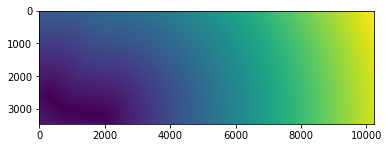

In [63]:
plt.imshow(distmap[2][1])

In [81]:
distmap[2][1].shape,roiimL.shape

((3460, 10235), (3460, 10235))

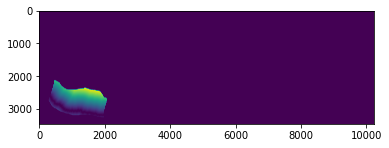

In [82]:
plt.imshow(np.multiply(distmap[2][1],roiimL==3))

In [84]:
np.max(distmap[2][1]),np.max(np.multiply(distmap[2][1],roiimL==3))

(8830.0, 696.5)

In [75]:
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
from skimage.morphology import remove_small_objects
import numpy as np
import cv2
from skimage.measure import label

# output precision is set to float16 manually here since our image is smaller than 16bit max: 65504.
# consider using 32bit if we use 40x images that can be bigger than 65504 in one dimension.

# must scale down input image to avoid crazy processing time
def dl2distancemap_byroiv2(roi,dl):

    roiarr = np.array(roi)
    roiimL = label(roiarr)
    numsec = np.max(roiimL)

    #we are gonna resize dl to roi size for faster calculations
    dl = dl.resize(roi.size)
    dlarr = np.array(dl)

    minszs = [100000,100000,1000,1000,1000,1000,1000,1000,1000,10000,1000] # 11 elements
    minszs = [round(_ / 16) for _ in minszs]

    # dist_layers = np.repeat(dist_layers[np.newaxis, ...], numsec, axis=0) #pre-allocate stacks for roi #oom issue
    # print(dist_layers.shape) #sanity check for output dimension

    #iterate each roi label
    dist_layers2=[]
    for roidx in range(1,numsec+1):
        dlarrm = np.multiply(dlarr, roiimL == roidx)
        dist_layers = np.zeros_like(dlarrm).astype(np.float16)  # pre-allocate x,y single layer
        dist_layers = np.repeat(dist_layers[np.newaxis, ...], len(minszs),axis=0)  # pre-allocate stacks for tissue classes
        for idx,minsz in enumerate(minszs):
            dltmp = dlarrm==idx+1
            dltmp2 = remove_small_objects(dltmp,minsz)
            dist = cv2.distanceTransform(np.invert(dltmp2).astype(np.uint8), cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
            #DO NOT use masksize 3 for L2. It is NOT accurate at all.
            #use maskSize of 5 or cv2.DIST_MASK_PRECISE. Note: precise is faster than 5.
            dist_layers[idx,...] = dist
        dist_layers2.append(dist_layers)
    return dist_layers2

start =time()
distmap = dl2distancemap_byroiv2(roi,dl) #11 channel dl distance
print(round(time()-start),'sec elapsed')

22 sec elapsed


In [71]:
roiarr = np.array(roi)
roiimL = label(roiarr)
numsec = np.max(roiimL)

#we are gonna resize dl to roi size for faster calculations
dl = dl.resize(roi.size)
dlarr = np.array(dl)

minszs = [100000,100000,1000,1000,1000,1000,1000,1000,1000,10000,1000] # 11 elements
minszs = [round(_ / 16) for _ in minszs]
dlarrm = np.multiply(dlarr, roiimL == 3)
dltmp = dlarrm==1
dltmp2 = remove_small_objects(dltmp,minszs[0])

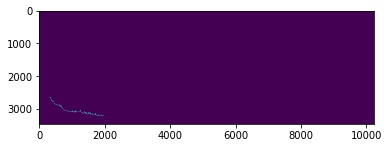

In [72]:
plt.imshow(dltmp2)

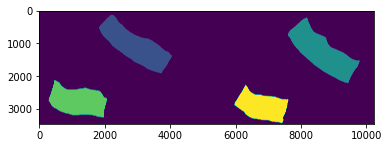

In [51]:
plt.imshow(roiimL)

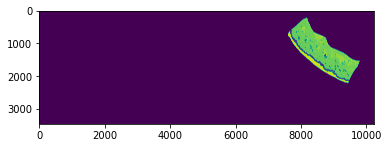

In [54]:
plt.imshow(dlarr2)

In [53]:
dlarr2 = np.multiply(dlarr, roiimL == 2)

In [2]:
jsonnm = jsons[1]
imID,ext = os.path.splitext(jsonnm)
dstfn = os.path.join(dst, '{}.pkl'.format(imID))
json = os.path.join(jsonsrc, jsonnm)
json = pd.read_json(json, orient='index')
json = pd.DataFrame(json[0].loc['nuc']).T.drop(columns=['type_prob'])
json = json[json['contour'].map(len) > 5].reset_index(drop=True)
json

bbox  \
0         [[3835, 14642], [3846, 14654]]   
1           [[393, 18165], [401, 18176]]   
2           [[940, 15650], [952, 15660]]   
3           [[965, 16018], [978, 16039]]   
4         [[1064, 15453], [1077, 15466]]   
...                                  ...   
106861  [[88288, 16531], [88307, 16542]]   
106862  [[88292, 16618], [88308, 16635]]   
106863  [[88292, 16556], [88307, 16570]]   
106864  [[88297, 16515], [88310, 16523]]   
106865  [[88302, 16536], [88317, 16553]]   

                                        centroid  \
0                    [2360.0, 16128.29292929293]   
1       [1785.5555555555557, 16780.537037037036]   
2        [1318.536842105263, 15281.252631578947]   
3       [1691.7692307692307, 15306.545454545454]   
4        [1122.739837398374, 15406.032520325203]   
...                                          ...   
106861   [88215.72142857143, 16616.614285714284]   
106862   [88306.23489932886, 16619.187919463086]   
106863   [88242.78709677419, 16619.348387096776]   
106864   [88198.01492537314, 16622.671641791043]   
106865    [88224.45505617978, 16629.52808988764]   

                                                  contour  type  
0       [[2360, 16123], [2358, 16125], [2357, 16125], ...  None  
1       [[1788, 16777], [1787, 16778], [1784, 16778], ...  None  
2       [[1317, 15276], [1316, 15277], [1315, 15277], ...  None  
3       [[1684, 15301], [1682, 15303], [1682, 15305], ...  None  
4       [[1121, 15400], [1118, 15403], [1118, 15404], ...  None  
...                                                   ...   ...  
106861  [[88216, 16608], [88215, 16609], [88215, 16610...  None  
106862  [[88308, 16612], [88303, 16617], [88302, 16617...  None  
106863  [[88244, 16612], [88243, 16613], [88242, 16613...  None  
106864  [[88199, 16617], [88196, 16620], [88196, 16621...  None  
106865  [[88226, 16622], [88225, 16623], [88224, 16623...  None  

[106866 rows x 4 columns]

In [58]:
ndpinm = jsonnm.replace(ext,'.ndpi')
ndpi = OpenSlide(os.path.join(ndpisrc, ndpinm))
ndpiw, ndpih = ndpi.dimensions
dlnm = jsonnm.replace(ext, '.tif')
dl = os.path.join(dlsrc, dlnm)
dl = Image.open(dl)
dlw, dlh = dl.size
rsfw_ndpi2dl = ndpiw / dlw
rsfh_ndpi2dl = ndpih / dlh
roinm = jsonnm.replace(ext, '_tissue_binary.tif')
roi = Image.open(os.path.join(roisrc, roinm))

In [4]:
roiw, roih = roi.size
rsfw_ndpi2roi = ndpiw / roiw
rsfh_ndpi2roi = ndpih / roih
# Continue from here: confirm if i can calculate correct tissue to cell distance without labeling roi
roiarr = np.array(roi)
roiarrL = label(roiarr)
roiimL = Image.fromarray(roiarrL)
json['inroi'] = json['centroid'].apply(lambda centroid: isinroi(centroid, roiimL, rsfw_ndpi2roi, rsfh_ndpi2roi))

In [16]:
minszs = [100000,100000,1000,1000,1000,1000,1000,1000,1000,10000,1000]
minszs = [round(_/4) for _ in minszs]
minszs

[25000, 25000, 250, 250, 250, 250, 250, 250, 250, 2500, 250]

In [5]:
json = json[json['inroi'] > 0].reset_index(drop=True)
json

bbox  \
0        [[4574, 18816], [4584, 18831]]   
1        [[4576, 18830], [4585, 18842]]   
2        [[4608, 18788], [4625, 18803]]   
3        [[4681, 18823], [4689, 18839]]   
4        [[4682, 18764], [4691, 18778]]   
...                                 ...   
81534  [[82150, 14309], [82164, 14326]]   
81535  [[82154, 14294], [82166, 14313]]   
81536  [[82157, 14336], [82170, 14357]]   
81537  [[82158, 14270], [82170, 14287]]   
81538  [[82158, 14424], [82171, 14445]]   

                                       centroid  \
0       [4487.330357142857, 18914.928571428572]   
1        [4499.267605633803, 18915.74647887324]   
2      [4458.9112903225805, 18951.379032258064]   
3       [4494.515789473684, 19020.715789473685]   
4       [4434.797872340426, 19022.425531914894]   
...                                         ...   
81534   [81900.84615384616, 14572.145299145299]   
81535   [81887.11585365854, 14575.762195121952]   
81536   [81929.74814814815, 14579.133333333333]   
81537   [81861.51145038167, 14579.709923664122]   
81538              [82017.85271317829, 14579.0]   

                                                 contour  type  inroi  
0      [[4486, 18910], [4485, 18911], [4483, 18911], ...  None      3  
1      [[4499, 18912], [4498, 18913], [4497, 18913], ...  None      3  
2      [[4464, 18944], [4463, 18945], [4461, 18945], ...  None      3  
3      [[4494, 19017], [4493, 19018], [4491, 19018], ...  None      3  
4      [[4434, 19018], [4433, 19019], [4432, 19019], ...  None      3  
...                                                  ...   ...    ...  
81534  [[81895, 14566], [81894, 14567], [81893, 14567...  None      2  
81535  [[81883, 14570], [81882, 14571], [81880, 14571...  None      2  
81536  [[81936, 14573], [81934, 14575], [81933, 14575...  None      2  
81537  [[81856, 14574], [81854, 14576], [81854, 14579...  None      2  
81538  [[82019, 14574], [82018, 14575], [82017, 14575...  None      2  

[81539 rows x 5 columns]

In [19]:
start =time()
distmap = dl2distancemap_byroi(roi,dl) #11 channel dl distance
print(round(time()-start),'sec elapsed')

361 sec elapsed


In [10]:
distmap[0][0].shape

(13840, 40938)

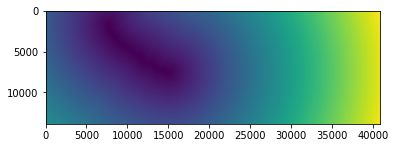

In [11]:
from matplotlib import pyplot as plt
plt.imshow(distmap[0][0])

In [ ]:
plt.imshow(dl)

In [ ]:
roi2 = roi.resize(dl.size)
roiarr = np.array(roi2)
dlarr = np.array(dl)

In [ ]:
dlarr = dlarr*roiarr
np.unique(dlarr)

In [ ]:
from skimage.measure import label
roiimL = label(roiarr)

In [ ]:
roiimL.dtype, np.unique(roiimL)

In [ ]:
roiA = roiimL==1

In [ ]:
dlarr,roiimL

In [69]:
dlarr2 = np.multiply(dlarr,roiimL==2)#became logical
np.unique(dlarr2)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [70]:
dltmp = dlarr2==2
from skimage.morphology import remove_small_objects
dltmp2 = remove_small_objects(dltmp,100000)
dist = cv2.distanceTransform(np.invert(dltmp2).astype(np.uint8), cv2.DIST_L2, 3)

In [40]:
cnt = json['centroid'].iloc[0]
cnt

[4487.330357142857, 18914.928571428572]

In [ ]:
# cell to tissue distance
# distances = [_[int(cnt[1]//rsfh_ndpi2dl),int(cnt[0]//rsfw_ndpi2dl)] for _ in dldist]
json['c2t_distance'] = json['centroid'].apply(lambda centroid: find_c2tdist(centroid, distmap, rsfw_ndpi2dl, rsfh_ndpi2dl))

In [143]:
import cv2
import numpy as np
from color_deconvolution import color_deconvolution
import scipy
from strel_line import strel_line
def cntarea(cnt):
    cnt = np.array(cnt)
    area = cv2.contourArea(cnt)
    return area

def cntperi(cnt):
    cnt = np.array(cnt)
    perimeter = cv2.arcLength(cnt,True)
    return perimeter


def cntMA(cnt):
    cnt = np.array(cnt)
    #Orientation, Aspect_ratio
    (x,y),(MA,ma),orientation = cv2.fitEllipse(cnt)
    return MA,ma,orientation

In [144]:
import pandas as pd
json = r'\\fatherserverdw\Q\research\images\skin_aging\wsi\hovernet_out\json\8.json'
json = pd.read_json(json, orient='index')
json = pd.DataFrame(json[0].loc['nuc']).T.drop(columns=['type_prob'])
json = json[json['contour'].map(len) > 5].reset_index(drop=True)
json['Area'] = json['contour'].apply(lambda row: cntarea(row))
json

bbox  \
0        [[1627, 12118], [1646, 12127]]   
1          [[3740, 8056], [3749, 8071]]   
2          [[3747, 8029], [3768, 8047]]   
3          [[3748, 8045], [3760, 8058]]   
4          [[3751, 8061], [3763, 8068]]   
...                                 ...   
83811  [[47028, 18229], [47040, 18238]]   
83812  [[47040, 18229], [47053, 18239]]   
83813  [[47097, 18361], [47116, 18373]]   
83814  [[47124, 18284], [47138, 18300]]   
83815  [[47325, 18392], [47355, 18406]]   

                                       centroid  \
0        [1881.754716981132, 11877.27358490566]   
1       [3966.7162162162163, 7840.310810810811]   
2       [3941.6615384615384, 7852.626923076923]   
3               [3954.541666666667, 7849.21875]   
4                    [3967.890625, 7852.359375]   
...                                         ...   
83811   [46905.51851851852, 18361.962962962964]   
83812  [46905.030303030304, 18373.555555555555]   
83813   [47038.33783783784, 18433.391891891893]   
83814  [46962.931818181816, 18458.234848484848]   
83815  [47069.282608695656, 18666.678260869565]   

                                                 contour  type   Area  
0      [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0  
1      [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5  
2      [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5  
3      [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5  
4      [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5  
...                                                  ...   ...    ...  
83811  [[46906, 18356], [46905, 18357], [46904, 18357...  None   65.5  
83812  [[46903, 18368], [46903, 18369], [46902, 18370...  None   81.5  
83813  [[47042, 18425], [47041, 18426], [47039, 18426...  None  126.5  
83814  [[46956, 18452], [46956, 18456], [46957, 18457...  None  111.5  
83815  [[47074, 18653], [47073, 18654], [47072, 18654...  None  197.5  

[83816 rows x 5 columns]

In [145]:
json.head()

bbox                                 centroid  \
0  [[1627, 12118], [1646, 12127]]   [1881.754716981132, 11877.27358490566]   
1    [[3740, 8056], [3749, 8071]]  [3966.7162162162163, 7840.310810810811]   
2    [[3747, 8029], [3768, 8047]]  [3941.6615384615384, 7852.626923076923]   
3    [[3748, 8045], [3760, 8058]]          [3954.541666666667, 7849.21875]   
4    [[3751, 8061], [3763, 8068]]               [3967.890625, 7852.359375]   

                                             contour  type   Area  
0  [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0  
1  [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5  
2  [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5  
3  [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5  
4  [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5

In [146]:
from PIL import Image
import os

In [147]:
roisrc = r'\\fatherserverdw\Q\research\images\skin_aging\annotation\roi\tif'
roifn = '8_tissue_binary.tif'
roiim = Image.open(os.path.join(roisrc,roifn))

In [148]:
roiim.size

(5583, 3257)

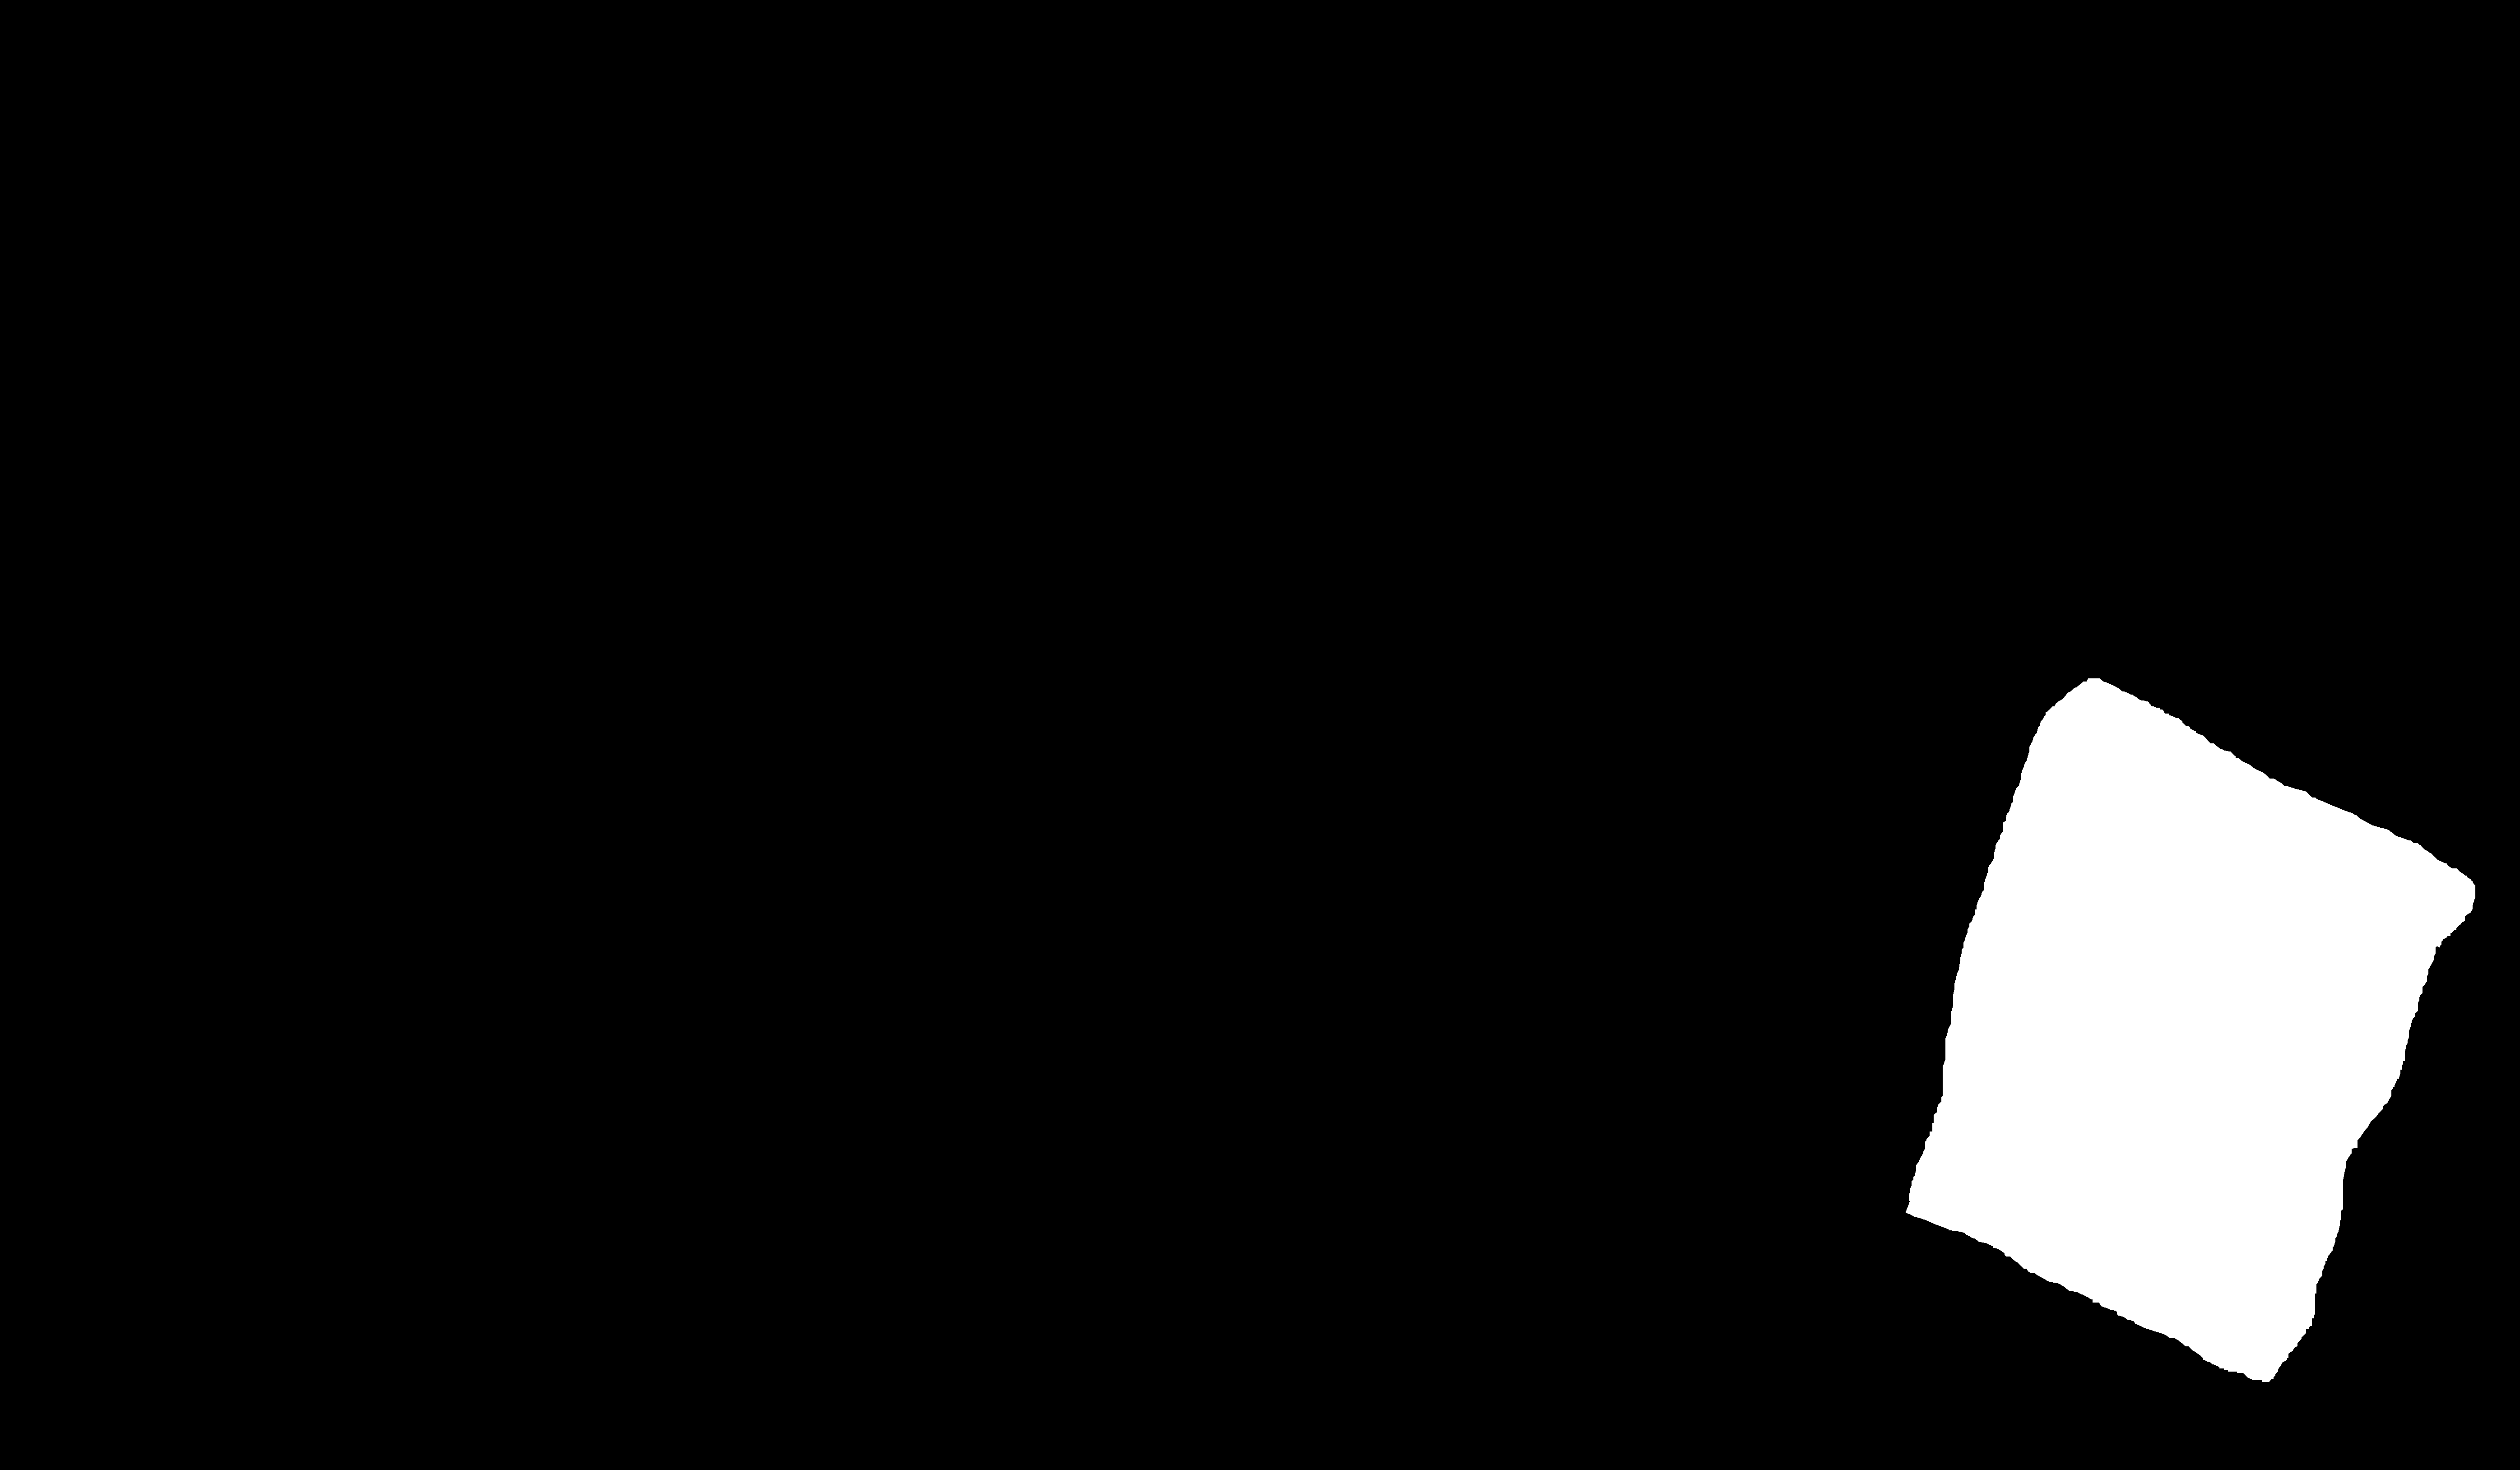

In [154]:
roiim

In [150]:
roiarr = np.array(roiim)

In [151]:
from skimage.measure import label
roiimL = label(roiarr)

In [87]:
for roidx in range(1,np.max(roiimL)+1):
    print(roidx)

1
2
3


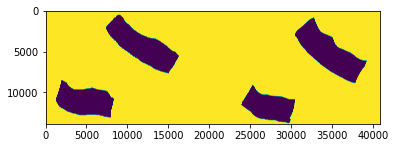

In [91]:
plt.imshow(roiimL==0)

In [89]:
np.max(roiimL)

4

In [ ]:
plt.imshow(roiimL)

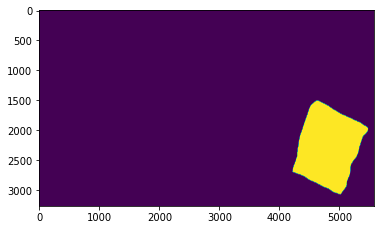

In [153]:
from matplotlib import pyplot as plt
plt.imshow(roiimL)

In [157]:
roiimL.dtype

dtype('int32')

In [159]:
Image.fromarray(roiimL.astype(np.uint8)).save('what.png')

In [ ]:

roiw, roih = roi.size
rsfw_ndpi2roi = ndpiw / roiw
rsfh_ndpi2roi = ndpih / roih
json['inroi'] = json['centroid'].apply(lambda row: isinroi(row, roiimL, rsfw_ndpi2roi, rsfh_ndpi2roi))

In [48]:
json['Perimeter'] = json['contour'].apply(lambda row: cntperi(row))
json

bbox  \
0        [[1627, 12118], [1646, 12127]]   
1          [[3740, 8056], [3749, 8071]]   
2          [[3747, 8029], [3768, 8047]]   
3          [[3748, 8045], [3760, 8058]]   
4          [[3751, 8061], [3763, 8068]]   
...                                 ...   
83811  [[47028, 18229], [47040, 18238]]   
83812  [[47040, 18229], [47053, 18239]]   
83813  [[47097, 18361], [47116, 18373]]   
83814  [[47124, 18284], [47138, 18300]]   
83815  [[47325, 18392], [47355, 18406]]   

                                       centroid  \
0        [1881.754716981132, 11877.27358490566]   
1       [3966.7162162162163, 7840.310810810811]   
2       [3941.6615384615384, 7852.626923076923]   
3               [3954.541666666667, 7849.21875]   
4                    [3967.890625, 7852.359375]   
...                                         ...   
83811   [46905.51851851852, 18361.962962962964]   
83812  [46905.030303030304, 18373.555555555555]   
83813   [47038.33783783784, 18433.391891891893]   
83814  [46962.931818181816, 18458.234848484848]   
83815  [47069.282608695656, 18666.678260869565]   

                                                 contour  type   Area  \
0      [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0   
1      [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5   
2      [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5   
3      [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5   
4      [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5   
...                                                  ...   ...    ...   
83811  [[46906, 18356], [46905, 18357], [46904, 18357...  None   65.5   
83812  [[46903, 18368], [46903, 18369], [46902, 18370...  None   81.5   
83813  [[47042, 18425], [47041, 18426], [47039, 18426...  None  126.5   
83814  [[46956, 18452], [46956, 18456], [46957, 18457...  None  111.5   
83815  [[47074, 18653], [47073, 18654], [47072, 18654...  None  197.5   

       Perimeter  
0      46.970562  
1      37.556349  
2      63.698484  
3      37.213203  
4      29.899495  
...          ...  
83811  32.727922  
83812  37.556349  
83813  49.698484  
83814  46.041630  
83815  71.698484  

[83816 rows x 6 columns]

In [49]:
json['Circularity'] = 4*np.pi*json['Area']/json['Perimeter']**2
json

bbox  \
0        [[1627, 12118], [1646, 12127]]   
1          [[3740, 8056], [3749, 8071]]   
2          [[3747, 8029], [3768, 8047]]   
3          [[3748, 8045], [3760, 8058]]   
4          [[3751, 8061], [3763, 8068]]   
...                                 ...   
83811  [[47028, 18229], [47040, 18238]]   
83812  [[47040, 18229], [47053, 18239]]   
83813  [[47097, 18361], [47116, 18373]]   
83814  [[47124, 18284], [47138, 18300]]   
83815  [[47325, 18392], [47355, 18406]]   

                                       centroid  \
0        [1881.754716981132, 11877.27358490566]   
1       [3966.7162162162163, 7840.310810810811]   
2       [3941.6615384615384, 7852.626923076923]   
3               [3954.541666666667, 7849.21875]   
4                    [3967.890625, 7852.359375]   
...                                         ...   
83811   [46905.51851851852, 18361.962962962964]   
83812  [46905.030303030304, 18373.555555555555]   
83813   [47038.33783783784, 18433.391891891893]   
83814  [46962.931818181816, 18458.234848484848]   
83815  [47069.282608695656, 18666.678260869565]   

                                                 contour  type   Area  \
0      [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0   
1      [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5   
2      [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5   
3      [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5   
4      [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5   
...                                                  ...   ...    ...   
83811  [[46906, 18356], [46905, 18357], [46904, 18357...  None   65.5   
83812  [[46903, 18368], [46903, 18369], [46902, 18370...  None   81.5   
83813  [[47042, 18425], [47041, 18426], [47039, 18426...  None  126.5   
83814  [[46956, 18452], [46956, 18456], [46957, 18457...  None  111.5   
83815  [[47074, 18653], [47073, 18654], [47072, 18654...  None  197.5   

       Perimeter  Circularity  
0      46.970562     0.478451  
1      37.556349     0.503375  
2      63.698484     0.716973  
3      37.213203     0.721411  
4      29.899495     0.695805  
...          ...          ...  
83811  32.727922     0.768448  
83812  37.556349     0.726107  
83813  49.698484     0.643597  
83814  46.041630     0.660972  
83815  71.698484     0.482789  

[83816 rows x 7 columns]

In [50]:
json['MA'] = json['contour'].apply(lambda row: cntMA(row))
json[['MA', 'ma', 'orientation']] = pd.DataFrame(json.MA.tolist())

In [51]:
from sklearn.neighbors import NearestNeighbors
points = pd.DataFrame(json.centroid.tolist()).astype('int')
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(points)
distances, indices = nbrs.kneighbors(points)
distance = distances[:,1]
json['dist2nearest'] = distance

In [53]:
json.head()

bbox                                 centroid  \
0  [[1627, 12118], [1646, 12127]]   [1881.754716981132, 11877.27358490566]   
1    [[3740, 8056], [3749, 8071]]  [3966.7162162162163, 7840.310810810811]   
2    [[3747, 8029], [3768, 8047]]  [3941.6615384615384, 7852.626923076923]   
3    [[3748, 8045], [3760, 8058]]          [3954.541666666667, 7849.21875]   
4    [[3751, 8061], [3763, 8068]]               [3967.890625, 7852.359375]   

                                             contour  type   Area  Perimeter  \
0  [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0  46.970562   
1  [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5  37.556349   
2  [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5  63.698484   
3  [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5  37.213203   
4  [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5  29.899495   

   Circularity         MA         ma  orientation  dist2nearest  
0     0.478451   8.425043  17.506271    15.408552     88.769364  
1     0.503375   5.584179  15.318203    68.177139     12.041595  
2     0.716973  15.692021  20.367672   157.260712     13.038405  
3     0.721411   8.986288  13.558445    60.039799     13.341664  
4     0.695805   6.660794  10.742558    10.978894     12.041595

In [66]:
json['oriA'] = json['orientation'][indices[:,1]].reset_index(drop=True)
json['oriB'] = json['orientation'][indices[:,2]].reset_index(drop=True)
json['local_align'] = json[['orientation','oriA','oriB']].std(axis=1)/json[['orientation','oriA','oriB']].mean(axis=1)

In [67]:
json.head()

bbox                                 centroid  \
0  [[1627, 12118], [1646, 12127]]   [1881.754716981132, 11877.27358490566]   
1    [[3740, 8056], [3749, 8071]]  [3966.7162162162163, 7840.310810810811]   
2    [[3747, 8029], [3768, 8047]]  [3941.6615384615384, 7852.626923076923]   
3    [[3748, 8045], [3760, 8058]]          [3954.541666666667, 7849.21875]   
4    [[3751, 8061], [3763, 8068]]               [3967.890625, 7852.359375]   

                                             contour  type   Area  Perimeter  \
0  [[1886, 11867], [1885, 11868], [1884, 11868], ...  None   84.0  46.970562   
1  [[3970, 7836], [3969, 7837], [3968, 7837], [39...  None   56.5  37.556349   
2  [[3940, 7843], [3939, 7844], [3938, 7844], [39...  None  231.5  63.698484   
3  [[3954, 7844], [3953, 7845], [3952, 7845], [39...  None   79.5  37.213203   
4  [[3969, 7847], [3968, 7848], [3966, 7848], [39...  None   49.5  29.899495   

   Circularity         MA         ma  orientation  dist2nearest       oriA  \
0     0.478451   8.425043  17.506271    15.408552     88.769364   9.045911   
1     0.503375   5.584179  15.318203    68.177139     12.041595  10.978894   
2     0.716973  15.692021  20.367672   157.260712     13.038405  32.288494   
3     0.721411   8.986288  13.558445    60.039799     13.341664  10.978894   
4     0.695805   6.660794  10.742558    10.978894     12.041595  68.177139   

         oriB  local_align  
0   33.463440     0.656105  
1   60.039799     0.666896  
2   60.039799     0.788801  
3  157.260712     0.978413  
4   60.039799     0.666896

In [72]:
from openslide import OpenSlide
slide = OpenSlide(r'\\fatherserverdw\Q\research\images\skin_aging\wsi\8.ndpi')

In [70]:
points.min(axis=0),points.max(axis=0)

(0    1299
 1    1087
 dtype: int32,
 0    49048
 1    28557
 dtype: int32)

In [73]:
slide.dimensions

(49152, 28672)

In [122]:
targetlvl = 2
targetdim = slide.level_dimensions[targetlvl]
targetdim

(12288, 7168)

In [123]:
im = slide.read_region(location=(0,0),level=targetlvl,size=targetdim)

In [124]:
region = np.array(im)[:,:,0:3]
rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                                 [0.072, 0.990, 0.105],
                                 [0.0, 0.0, 0.0]])
rgb_from_hed[2, :] = np.cross(rgb_from_hed[0, :], rgb_from_hed[1, :])
hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
Hema = color_deconvolution(region, hed_from_rgb)[:, :, 0]

In [125]:
Hema_N = cv2.normalize(Hema,  None,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [131]:
threshold = 20
bwt = Image.fromarray(Hema_N).point(lambda x: 255 if x > threshold else 0)
bwt

In [132]:
bwt.save('ECMbw.png')

In [133]:
maxOfOpenings = np.zeros_like(bwt)
angleOfMax = np.zeros_like(bwt)

In [135]:
lengthOfLine = 30
for theta in range(0,190,5):
    SE = strel_line(lengthOfLine, theta)

    thisImage = imopen(grayImage, SE);
    maxOfOpenings = max(maxOfOpenings, thisImage);
    % Find out where this image is the max.
    thisIsMax = (thisImage == maxOfOpenings);
    % That is a "map" of where this angle was the max.
    % Store the angle into angleOfMax at those locations.
    if theta==185
        angleOfMax180 = angleOfMax;
        angleOfMax180(thisIsMax) = theta;
    else
        angleOfMax(thisIsMax) = theta;

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185


In [ ]:
angleOfMax180(angleOfMax==5)=5;
angleOfMax90 = angleOfMax180;
angleOfMax90(angleOfMax90>90)=180-angleOfMax90(angleOfMax90>90);

In [ ]:
interd = bwdist(~interstitialbw)
interskel = bwmorph(interstitialbw,'skel',Inf); %To-Do: clean up skeleton.
inter_thick_map = interd.*interskel
inter_thick_map(inter_thick_map<2)=0; %To-Do: filter by object analysis instead.
inter_thick = interd(interskel)
angleval=angleOfMax90(interskel & inter_thick_map>2 & 0<=angleOfMax90);

In [ ]:
meanangle = mean(angleval);
stdangle = std(angleval);